In [ ]:
import pandas as pd 
import numpy as np 
import seaborn as sns
import matplotlib.pyplot as plt
import sklearn
from sklearn import tree
from sklearn.model_selection import train_test_split
from sklearn import metrics

import os  # operating system interface 

print(os.getcwd())

/content


# Eyeballing Data

In [ ]:
#read data
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
file = 'drive/MyDrive/Fraud.csv'
df = pd.read_csv(file)

In [ ]:
df.head(n=6)

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0
5,1,PAYMENT,7817.71,C90045638,53860.0,46042.29,M573487274,0.0,0.0,0,0


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6362620 entries, 0 to 6362619
Data columns (total 11 columns):
 #   Column          Dtype  
---  ------          -----  
 0   step            int64  
 1   type            object 
 2   amount          float64
 3   nameOrig        object 
 4   oldbalanceOrg   float64
 5   newbalanceOrig  float64
 6   nameDest        object 
 7   oldbalanceDest  float64
 8   newbalanceDest  float64
 9   isFraud         int64  
 10  isFlaggedFraud  int64  
dtypes: float64(5), int64(3), object(3)
memory usage: 534.0+ MB


In [ ]:
df.describe()

,step,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
count,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06
mean,2.433972e+02,1.798619e+05,8.338831e+05,8.551137e+05,1.100702e+06,1.224996e+06,1.290820e-03,2.514687e-06
std,1.423320e+02,6.038582e+05,2.888243e+06,2.924049e+06,3.399180e+06,3.674129e+06,3.590480e-02,1.585775e-03
min,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,1.560000e+02,1.338957e+04,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,2.390000e+02,7.487194e+04,1.420800e+04,0.000000e+00,1.327057e+05,2.146614e+05,0.000000e+00,0.000000e+00
75%,3.350000e+02,2.087215e+05,1.073152e+05,1.442584e+05,9.430367e+05,1.111909e+06,0.000000e+00,0.000000e+00
max,7.430000e+02,9.244552e+07,5.958504e+07,4.958504e+07,3.560159e+08,3.561793e+08,1.000000e+00,1.000000e+00


In [ ]:
df.describe(include='all')

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
count,6.362620e+06,6362620,6.362620e+06,6362620,6.362620e+06,6.362620e+06,6362620,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06
unique,NaN,5,NaN,6353307,NaN,NaN,2722362,NaN,NaN,NaN,NaN
top,NaN,CASH_OUT,NaN,C1902386530,NaN,NaN,C1286084959,NaN,NaN,NaN,NaN
freq,NaN,2237500,NaN,3,NaN,NaN,113,NaN,NaN,NaN,NaN
mean,2.433972e+02,NaN,1.798619e+05,NaN,8.338831e+05,8.551137e+05,NaN,1.100702e+06,1.224996e+06,1.290820e-03,2.514687e-06
std,1.423320e+02,NaN,6.038582e+05,NaN,2.888243e+06,2.924049e+06,NaN,3.399180e+06,3.674129e+06,3.590480e-02,1.585775e-03
min,1.000000e+00,NaN,0.000000e+00,NaN,0.000000e+00,0.000000e+00,NaN,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,1.560000e+02,NaN,1.338957e+04,NaN,0.000000e+00,0.000000e+00,NaN,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,2.390000e+02,NaN,7.487194e+04,NaN,1.420800e+04,0.000000e+00,NaN,1.327057e+05,2.146614e+05,0.000000e+00,0.000000e+00
75%,3.350000e+02,NaN,2.087215e+05,NaN,1.073152e+05,1.442584e+05,NaN,9.430367e+05,1.111909e+06,0.000000e+00,0.000000e+00


In [ ]:
# Count the frequency of good and bad credit risks
df.isFraud.value_counts()

0    6354407
1       8213
Name: isFraud, dtype: int64

In [ ]:
df['type'] = df['type'].astype('category')
df['nameOrig'] = df['nameOrig'].astype('string')
df['nameDest'] = df['nameDest'].astype('string')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6362620 entries, 0 to 6362619
Data columns (total 11 columns):
 #   Column          Dtype   
---  ------          -----   
 0   step            int64   
 1   type            category
 2   amount          float64 
 3   nameOrig        string  
 4   oldbalanceOrg   float64 
 5   newbalanceOrig  float64 
 6   nameDest        string  
 7   oldbalanceDest  float64 
 8   newbalanceDest  float64 
 9   isFraud         int64   
 10  isFlaggedFraud  int64   
dtypes: category(1), float64(5), int64(3), string(2)
memory usage: 491.5 MB


In [ ]:
# The target variable has only two states so that we can store it as a boolean
df['isFraud'] = df['isFraud'].astype('bool')
df['isFlaggedFraud'] = df['isFlaggedFraud'].astype('bool')

# For simplicity, we also convert LOAN to a float so that all numeric variables are of type float
df['step'] = df['step'].astype(np.float64)

# Last, let's change all numeric variables from float64 to float32 to reduce memory consumption
num_vars = df.select_dtypes(include=np.float64).columns
df[num_vars] = df[num_vars].astype(np.float32)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6362620 entries, 0 to 6362619
Data columns (total 11 columns):
 #   Column          Dtype   
---  ------          -----   
 0   step            float32 
 1   type            category
 2   amount          float32 
 3   nameOrig        string  
 4   oldbalanceOrg   float32 
 5   newbalanceOrig  float32 
 6   nameDest        string  
 7   oldbalanceDest  float32 
 8   newbalanceDest  float32 
 9   isFraud         bool    
 10  isFlaggedFraud  bool    
dtypes: bool(2), category(1), float32(6), string(2)
memory usage: 260.9 MB


Note that the conversion from object to category has reduced the amount of memory that the data frame consumes. changing some more data types. The target variable in our case is isFraud. It is stored as an integer but we know that it has only two states. So we can convert the target to a boolean. Further, we might not need the numeric precision that the data type float64 or int64 provides. Downcasting to 32 bit precision should not affect modeling results too much. On my machine, we need 303.4 MB after the translation, whereas we needed more than  534 MB for the original data frame. As we can see with millions of observations the above conversions will result in a significant reduction of memory consumption.

In [ ]:
# count the total number of missing values
df.isnull().sum().sum()

0

We can that our data is free from any missing values. 

In [ ]:
df_copy = df

# Data import, EDA and data cleaning

### Univariate analysis of numeric features

<Figure size 864x576 with 0 Axes>

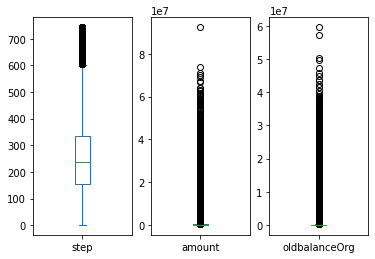

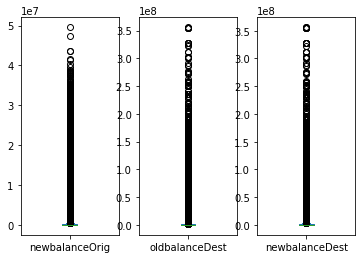

In [ ]:
plt.figure(figsize=(12,8))  # enlarge the figure
num_vars = df.select_dtypes(include="float32")
half = np.ceil(num_vars.shape[1] / 2).astype(int)  # for cosmetic reasons we split the plots into two rows
num_vars.iloc[:, 0:half].plot(kind = 'box', subplots=True);
num_vars.iloc[:, half:num_vars.shape[1]].plot(kind = 'box', subplots=True);

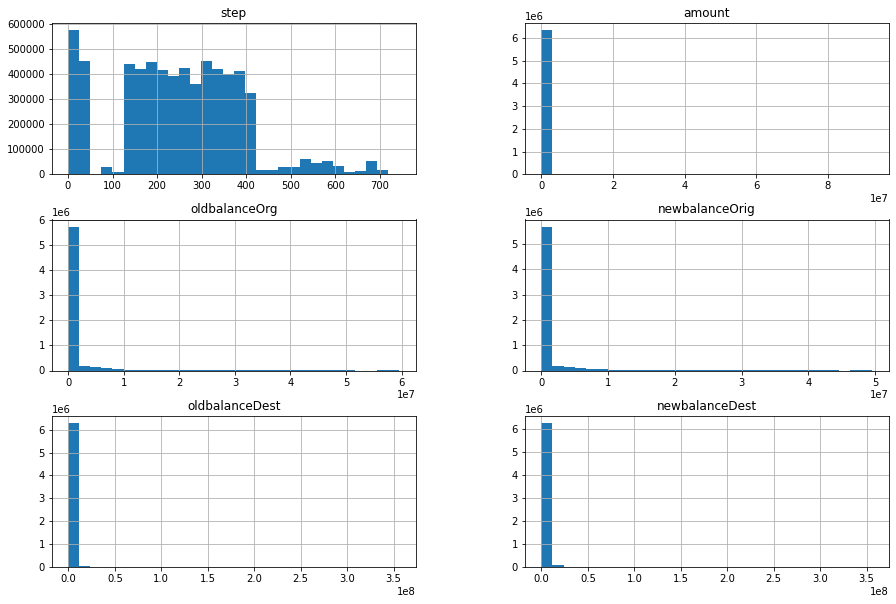

In [ ]:
 df_select = df.select_dtypes(include='float32')
 df.select_dtypes(include='float32').hist(bins=30, figsize=(15, 10));

### Handling outliers based on IQR

In [ ]:
def outlier_truncation(x, factor=1.5):
    x_new = x.copy()
    
    # Calculate IQR
    IQR = x.quantile(0.75) - x.quantile(0.25) 
    
    # Define upper/lower bound
    upper = x.quantile(0.75) + factor*IQR
    lower = x.quantile(0.25) - factor*IQR
    
    # Truncation
    x_new[x < lower] = lower
    x_new[x > upper] = upper
    
    return x_new

In [ ]:
# Select numeric variables for outlier treatment. 
num_cols = [x for x in df.columns if df[x].dtype == 'float32']  
df[num_cols] = df[num_cols].apply(outlier_truncation, axis=0, args=(3,))  
df.describe()

,step,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest
count,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06
mean,2.419529e+02,1.412283e+05,9.747583e+04,1.215172e+05,7.316314e+05,8.569036e+05
std,1.421901e+02,1.785320e+05,1.541414e+05,2.079487e+05,1.159244e+06,1.313869e+06
min,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,1.560000e+02,1.338957e+04,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,2.390000e+02,7.487194e+04,1.420800e+04,0.000000e+00,1.327057e+05,2.146614e+05
75%,3.350000e+02,2.087215e+05,1.073152e+05,1.442584e+05,9.430367e+05,1.111909e+06
max,7.430000e+02,7.947172e+05,4.292607e+05,5.770336e+05,3.772147e+06,4.447637e+06


<Figure size 864x576 with 0 Axes>

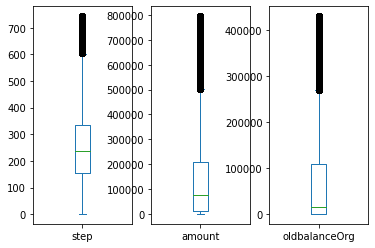

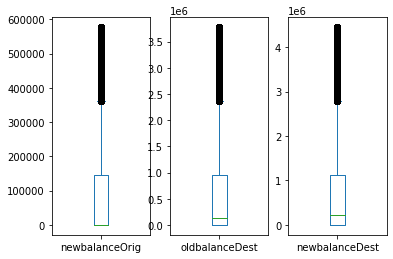

In [ ]:
#boxplot after treating the outliers
plt.figure(figsize=(12,8))  # enlarge the figure
num_vars = df.select_dtypes(include="float32")
half = np.ceil(num_vars.shape[1] / 2).astype(int)  # for cosmetic reasons we split the plots into two rows
num_vars.iloc[:, 0:half].plot(kind = 'box', subplots=True);
num_vars.iloc[:, half:num_vars.shape[1]].plot(kind = 'box', subplots=True);

### Multicollinearity check

In [ ]:
pip install dython


In [ ]:
from dython.nominal import associations

In [ ]:
df = pd.get_dummies(df, columns = ['type'], drop_first=True)

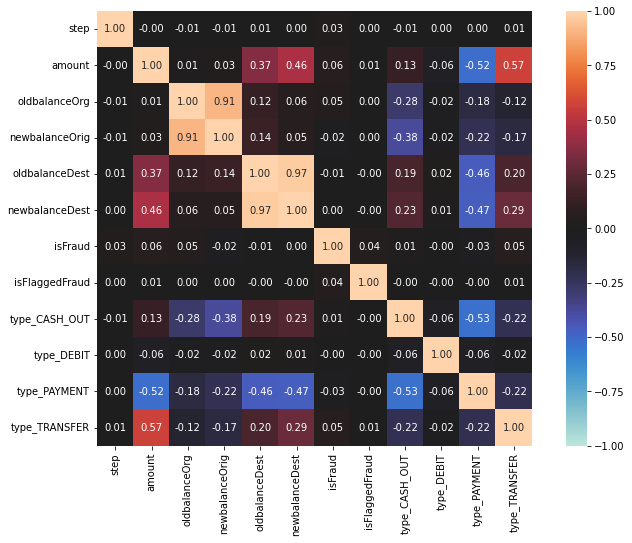

{'ax': <matplotlib.axes._subplots.AxesSubplot at 0x7f7dcd36cad0>,
 'corr':                     step    amount  ...  type_PAYMENT  type_TRANSFER
 step            1.000000 -0.002539  ...      0.004927       0.006925
 amount         -0.002539  1.000000  ...     -0.518919       0.568388
 oldbalanceOrg  -0.013195  0.012276  ...     -0.177903      -0.117659
 newbalanceOrig -0.012529  0.025868  ...     -0.222564      -0.167727
 oldbalanceDest  0.005751  0.366827  ...     -0.455336       0.198863
 newbalanceDest  0.000395  0.464285  ...     -0.466532       0.292360
 isFraud         0.031564  0.061826  ...     -0.025696       0.053874
 isFlaggedFraud  0.003277  0.005165  ...     -0.001133       0.005245
 type_CASH_OUT  -0.012919  0.128501  ...     -0.526422      -0.222672
 type_DEBIT      0.002869 -0.062200  ...     -0.057868      -0.024478
 type_PAYMENT    0.004927 -0.518919  ...      1.000000      -0.216110
 type_TRANSFER   0.006925  0.568388  ...     -0.216110       1.000000
 
 [12 rows x 12

In [ ]:
associations(df.iloc[0:6362619,[0,1,3,4,6,7,8,9,10,11,12,13]],figsize = (12,8))

As we can see from the above associations plot that the associations are low to medium between the numerical features. These low to medium associations won't have a significant impact model's prediction power. Usually high  multi-collinearity among features has a severe impact on regression models. Although low to medium collinearlity(<0.5) among feature space does not pose a threat to model performance. 
Multicollinearity is problematic for estimation of the effects, for coefficients of the individual variables - hence, the problem with regression. So it can have some effect on logistic regression model, but it is highly unlikely to cause any issue on classification models, decision trees, random forest, gradient boosting, and so on. So we do not treat this insignificant association among variables.

In [ ]:
df.head(n=5)

,step,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud,type_CASH_OUT,type_DEBIT,type_PAYMENT,type_TRANSFER
0,1.0,9839.639648,C1231006815,170136.0,160296.359375,M1979787155,0.0,0.0,False,False,0,0,1,0
1,1.0,1864.280029,C1666544295,21249.0,19384.720703,M2044282225,0.0,0.0,False,False,0,0,1,0
2,1.0,181.000000,C1305486145,181.0,0.000000,C553264065,0.0,0.0,True,False,0,0,0,1
3,1.0,181.000000,C840083671,181.0,0.000000,C38997010,21182.0,0.0,True,False,1,0,0,0
4,1.0,11668.139648,C2048537720,41554.0,29885.859375,M1230701703,0.0,0.0,False,False,0,0,1,0


# Model Training

### Feature Selection

In [ ]:
# Extract target variable and feature matrix 
X = df.drop(['isFraud','nameOrig','nameDest'], axis=1) 
y = df[['isFraud']]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.3)       

In [ ]:
from sklearn.linear_model import LogisticRegression # We will use sklearn here as it is required in the next algorithms
from sklearn.metrics import roc_auc_score
clf = LogisticRegression(random_state=888, max_iter=200)
clf.fit(X_train,  np.ravel(y_train.values))
y_pred = clf.predict(X_test)
roc_auc_score(y_test, y_pred) 

0.5352132621694579

In [ ]:
class filter_binary_target:
    def __init__(self, df, target):
        self.target = target
        self.data_head = df.head()

    def auto_filter_binary_target(self):
        print('Data must be in a clean pandas DataFrame. Categorical variables must be of data type bool or category. Continuous variables must be int64 or float64.')
        data_no_target = df.drop(columns=self.target)
        columns = ['Data Type', 'Metric', 'Score']
        index = data_no_target.columns
        result = pd.DataFrame(index=index, columns=columns)

        for col in data_no_target:
            if data_no_target.dtypes[col] == 'bool' or data_no_target.dtypes[col].name == 'category':
                result.loc[col, 'Data Type'] = "discrete"
                result.loc[col, 'Metric'] = "IV"
                result.loc[col, 'Score'] = self.IV_binary_target(feature=col)

            if data_no_target.dtypes[col] == 'int64' or data_no_target.dtypes[col] == 'float32':
                result.loc[col, 'Data Type'] = "continuous"
                result.loc[col, 'Metric'] = "Fisher"
                result.loc[col, 'Score'] = self.fisher_binary_target(feature=col)

        return result

    def IV_binary_target(self, feature):  # same code as used above
        data = pd.DataFrame()
    
        data['Count'] = df[feature].value_counts()
        data['Bad'] = df.groupby([feature])[self.target].sum()
        data['Good'] = data['Count'] - data['Bad']
    
        data["Distribution Bad"] = data["Bad"] / data["Bad"].sum()
        data["Distribution Good"] = data["Good"] / data["Good"].sum()
    
        data['WOE'] = np.log(data["Distribution Good"] / data["Distribution Bad"])
        data.replace({"WOE": {np.inf: 0, -np.inf: 0}})

        data["IV"] = data["WOE"] * (data["Distribution Good"] - data["Distribution Bad"])

        iv = data["IV"].sum()

        return iv

    def fisher_binary_target(self, feature):
        mu_0 = df.groupby(df[self.target])[feature].mean()[0]
        mu_1 = df.groupby(df[self.target])[feature].mean()[1]
        var_0 = df.groupby(df[self.target])[feature].var()[0]
        var_1 = df.groupby(df[self.target])[feature].var()[1]

        num = abs(mu_0 - mu_1)
        den = (var_0 + var_1) ** 0.5
        score = num/den
    
        return score

    def pearson(self, feature):  # since our target is binary, we actually don't need this. However, if you would like to expand this class, you can use this code
        mean_feature = df[feature].mean()
        mean_target = df[self.target].mean()
        num = ((df[feature] - mean_feature)*(df[self.target] - mean_target)).sum()
        den = (((df[feature] - mean_feature)**2).sum() * ((df[self.target] - mean_target)**2).sum()) ** .5
        rho = num/den
        return rho

In [ ]:
df['type_CASH_OUT'] = df['type_CASH_OUT'].astype('bool')
df['type_DEBIT'] = df['type_DEBIT'].astype('bool')
df['type_PAYMENT'] = df['type_PAYMENT'].astype('bool')
df['type_TRANSFER'] = df['type_TRANSFER'].astype('bool')
df_sel = df.drop(['isFraud','nameOrig','nameDest'], axis=1)
filter = filter_binary_target(df=df_sel, target="isFraud")

In [ ]:
df_sel.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6362620 entries, 0 to 6362619
Data columns (total 11 columns):
 #   Column          Dtype  
---  ------          -----  
 0   step            float32
 1   amount          float32
 2   oldbalanceOrg   float32
 3   newbalanceOrig  float32
 4   oldbalanceDest  float32
 5   newbalanceDest  float32
 6   isFlaggedFraud  bool   
 7   type_CASH_OUT   bool   
 8   type_DEBIT      bool   
 9   type_PAYMENT    bool   
 10  type_TRANSFER   bool   
dtypes: bool(5), float32(6)
memory usage: 176.0 MB


In [ ]:
filter.auto_filter_binary_target()

Data must be in a clean pandas DataFrame. Categorical variables must be of data type bool or category. Continuous variables must be int64 or float64.


/usr/local/lib/python3.7/dist-packages/pandas/core/arraylike.py:364: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


,Data Type,Metric,Score
step,continuous,Fisher,0.483505
amount,continuous,Fisher,0.850956
nameOrig,NaN,NaN,NaN
oldbalanceOrg,continuous,Fisher,0.868134
newbalanceOrig,continuous,Fisher,0.498024
nameDest,NaN,NaN,NaN
oldbalanceDest,continuous,Fisher,0.271064
newbalanceDest,continuous,Fisher,0.001466
isFlaggedFraud,discrete,IV,inf
type_CASH_OUT,discrete,IV,0.092388


From the above correlation of feature variables with binary target variable, we obtain Fisher score and Information value. We cannot directly compare IV and Fisher scores but we can judge them relative to other variables calculated with the same score. It can be seen that oldbalanceDest and newbalanceDestare low on Fischer scale. So it might be useful to not include them in the data modeling. Looking at the IV scale given below, we can see that type_CASH_OUT is having weak predictive power. And type_TRANSFER has susppiciously high predictive power. We would like to keep them in the model for now. 
We could have 

In [ ]:
df_sel.isFlaggedFraud.value_counts()

False    6362604
True          16
Name: isFlaggedFraud, dtype: int64

In [ ]:
df_sel.type_DEBIT.value_counts()

False    6321188
True       41432
Name: type_DEBIT, dtype: int64

#### Testing Feature Selection

Let's use a Logistic regression model to compare the predictive performance of the model containing the entire feature space with the model that excludes the features "oldbalanceDest" and "newbalanceDest" from it's feature space. The performance measured used is AUC. 

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6362620 entries, 0 to 6362619
Data columns (total 14 columns):
 #   Column          Dtype  
---  ------          -----  
 0   step            float32
 1   amount          float32
 2   nameOrig        string 
 3   oldbalanceOrg   float32
 4   newbalanceOrig  float32
 5   nameDest        string 
 6   oldbalanceDest  float32
 7   newbalanceDest  float32
 8   isFraud         bool   
 9   isFlaggedFraud  bool   
 10  type_CASH_OUT   bool   
 11  type_DEBIT      bool   
 12  type_PAYMENT    bool   
 13  type_TRANSFER   bool   
dtypes: bool(6), float32(6), string(2)
memory usage: 279.1 MB


In [ ]:
X = df.drop(['isFraud','nameOrig','nameDest','oldbalanceDest','newbalanceDest'], axis=1) 
y = df[['isFraud']]
X_train_feature_test, X_test_feature_test, y_train_feature_test, y_test_feature_test = train_test_split(X, y, test_size=.3)    

In [ ]:
from sklearn.linear_model import LogisticRegression
clf = LogisticRegression(random_state=888, max_iter=200)
clf.fit(X_train_feature_test,  np.ravel(y_train_feature_test.values))
y_pred = clf.predict(X_test_feature_test)
roc_auc_score(y_test_feature_test, y_pred)

0.5311258278124382

In [ ]:
X_1 = df.drop(['isFraud','nameOrig','nameDest'], axis=1) 
y_1 = df[['isFraud']]
X_train, X_test, y_train, y_test = train_test_split(X_1, y_1, test_size=.3) 

In [ ]:
clf = LogisticRegression(random_state=888, max_iter=200)
clf.fit(X_train,  np.ravel(y_train.values))
y_pred_1 = clf.predict(X_test)
roc_auc_score(y_test, y_pred_1)

0.5409431343964635

We can see that removing features improves the logit model and so we will keep working with the feature space that excludes "oldbalanceDest" and "newbalanceDest".

#Testing predictive power based of the model based on dummy data and WOE data


### WOE(Weight of Evidence)

In [ ]:
!pip install scorecardpy
import scorecardpy as sc

     |████████████████████████████████| 55 kB 3.1 MB/s 
  Created wheel for scorecardpy: filename=scorecardpy-0.1.9.2-py3-none-any.whl size=57843 sha256=4d9b607e01ad1b04530de896c882ffb4c9716eccf80ec31751c699db8705986a
  Stored in directory: /root/.cache/pip/wheels/9d/50/52/715367c478fd2e2317070ccf6539b2c29fc8168144cfbfaeac
Successfully built scorecardpy


In [ ]:
# Extract target variable and feature matrix 
X_woe = df_copy.drop(['isFraud','nameOrig','nameDest'], axis=1) 
y_woe = df_copy[['isFraud']]
X_train_woe, X_test_woe, y_train_woe, y_test_woe = train_test_split(X_woe, y_woe, test_size=.3)    
train_df = pd.concat([X_train_woe, y_train_woe], axis=1, join="inner")

In [ ]:
X_train_woe.shape,X_test_woe.shape,y_train_woe.shape,y_test_woe.shape

((4453834, 8), (1908786, 8), (4453834, 1), (1908786, 1))

[INFO] creating woe binning ...
Binning on 4453834 rows and 2 columns in 00:00:50


{'type': <Figure size 432x288 with 2 Axes>}

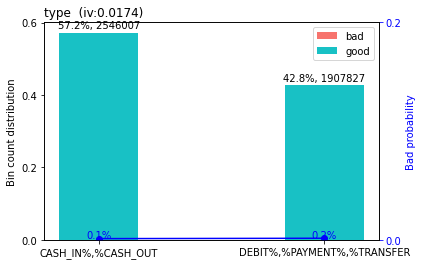

In [ ]:
bins = sc.woebin(train_df, y="isFraud", x='type')

sc.woebin_plot(bins)

In [ ]:
X_train_woe_1 = sc.woebin_ply(X_train_woe, bins) 

[INFO] converting into woe values ...


/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1951: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[selected_item_labels] = value


Woe transformating on 4453834 rows and 1 columns in 00:01:10


In [ ]:
X_train_woe_1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4453834 entries, 0 to 6362619
Data columns (total 8 columns):
 #   Column          Dtype  
---  ------          -----  
 0   oldbalanceDest  float32
 1   newbalanceOrig  float32
 2   amount          float32
 3   step            float32
 4   isFlaggedFraud  bool   
 5   oldbalanceOrg   float32
 6   newbalanceDest  float32
 7   type_woe        float64
dtypes: bool(1), float32(6), float64(1)
memory usage: 174.1 MB


In [ ]:
X_test_woe = sc.woebin_ply(X_test_woe, bins)



[INFO] converting into woe values ...


/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1951: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[selected_item_labels] = value


Woe transformating on 1908786 rows and 1 columns in 00:00:35


In [ ]:
X_test_woe.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1908786 entries, 8 to 6362611
Data columns (total 8 columns):
 #   Column          Dtype  
---  ------          -----  
 0   oldbalanceDest  float32
 1   newbalanceOrig  float32
 2   amount          float32
 3   step            float32
 4   isFlaggedFraud  bool   
 5   oldbalanceOrg   float32
 6   newbalanceDest  float32
 7   type_woe        float64
dtypes: bool(1), float32(6), float64(1)
memory usage: 74.6 MB


In [ ]:
clf = LogisticRegression(random_state=888, max_iter=200)
clf.fit(X_train_woe_1,  np.ravel(y_train))
y_pred_woe = clf.predict(X_test_woe)
roc_auc_score(y_test, y_pred_woe)

0.5

In [ ]:
X_train_woe_1 = X_train_woe_1.drop(['oldbalanceDest','newbalanceDest'],axis = 1)


In [ ]:
X_test_woe = X_test_woe.drop(['oldbalanceDest','newbalanceDest'],axis = 1)

In [ ]:
clf = LogisticRegression(random_state=888, max_iter=200)
clf.fit(X_train_woe_1,  np.ravel(y_train))
y_pred_woe = clf.predict(X_test_woe)
roc_auc_score(y_test, y_pred_woe)

0.5

We can see that predictive power of model with dummy variables is higher than that of Weight of Evidence model.

### Testing model on standardized data

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6362620 entries, 0 to 6362619
Data columns (total 14 columns):
 #   Column          Dtype  
---  ------          -----  
 0   step            float32
 1   amount          float32
 2   nameOrig        string 
 3   oldbalanceOrg   float32
 4   newbalanceOrig  float32
 5   nameDest        string 
 6   oldbalanceDest  float32
 7   newbalanceDest  float32
 8   isFraud         bool   
 9   isFlaggedFraud  bool   
 10  type_CASH_OUT   bool   
 11  type_DEBIT      bool   
 12  type_PAYMENT    bool   
 13  type_TRANSFER   bool   
dtypes: bool(6), float32(6), string(2)
memory usage: 279.1 MB


In [ ]:
from sklearn.preprocessing import StandardScaler
standardscaler = StandardScaler()
numeric_cols = list(df.drop(['nameOrig','nameDest','isFraud'],axis = 1).columns)

standard = StandardScaler()

X_train_scaled = X_train.copy()
X_test_scaled = X_test.copy()

X_train_scaled[numeric_cols] = standard.fit_transform(X_train_scaled[numeric_cols])



In [ ]:
X_test_scaled[numeric_cols] = standard.fit_transform(X_test_scaled[numeric_cols])

In [ ]:
X_train_scaled.shape,X_test_scaled.shape

((4453834, 11), (1908786, 11))

In [ ]:
X_train_scaled.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4453834 entries, 3666151 to 4210380
Data columns (total 11 columns):
 #   Column          Dtype  
---  ------          -----  
 0   step            float64
 1   amount          float64
 2   oldbalanceOrg   float64
 3   newbalanceOrig  float64
 4   oldbalanceDest  float64
 5   newbalanceDest  float64
 6   isFlaggedFraud  float64
 7   type_CASH_OUT   float64
 8   type_DEBIT      float64
 9   type_PAYMENT    float64
 10  type_TRANSFER   float64
dtypes: float64(11)
memory usage: 407.8 MB


In [ ]:
X_train_scaled.describe()

,step,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFlaggedFraud,type_CASH_OUT,type_DEBIT,type_PAYMENT,type_TRANSFER
count,4.453834e+06,4.453834e+06,4.453834e+06,4.453834e+06,4.453834e+06,4.453834e+06,4.453834e+06,4.453834e+06,4.453834e+06,4.453834e+06,4.453834e+06
mean,-2.675316e-16,-8.569255e-16,2.595593e-15,1.421098e-15,-8.732263e-15,-1.561713e-15,4.781060e-14,2.924396e-15,4.971685e-15,-7.771319e-15,9.630350e-15
std,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00
min,-1.703551e+00,-7.989239e-01,-6.331142e-01,-5.858542e-01,-6.372752e-01,-6.529057e-01,-1.772955e-03,-7.363250e-01,-8.084239e-02,-7.146770e-01,-3.024038e-01
25%,-6.141253e-01,-7.241003e-01,-6.331142e-01,-5.858542e-01,-6.372752e-01,-6.529057e-01,-1.772955e-03,-7.363250e-01,-8.084239e-02,-7.146770e-01,-3.024038e-01
50%,-3.075535e-02,-3.806557e-01,-5.411835e-01,-5.858542e-01,-5.220395e-01,-4.902273e-01,-1.772955e-03,-7.363250e-01,-8.084239e-02,-7.146770e-01,-3.024038e-01
75%,6.369573e-01,3.661988e-01,6.190271e-02,1.144663e-01,1.795777e-01,1.897663e-01,-1.772955e-03,1.358096e+00,-8.084239e-02,1.399234e+00,-3.024038e-01
max,3.511636e+00,3.638808e+00,2.146699e+00,2.212008e+00,2.625740e+00,2.713433e+00,5.640301e+02,1.358096e+00,1.236975e+01,1.399234e+00,3.306836e+00


In [ ]:
X_train_scaled.shape

(4453834, 11)

In [ ]:
X_test_scaled.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1908786 entries, 449024 to 729674
Data columns (total 11 columns):
 #   Column          Dtype  
---  ------          -----  
 0   step            float64
 1   amount          float64
 2   oldbalanceOrg   float64
 3   newbalanceOrig  float64
 4   oldbalanceDest  float64
 5   newbalanceDest  float64
 6   isFlaggedFraud  float64
 7   type_CASH_OUT   float64
 8   type_DEBIT      float64
 9   type_PAYMENT    float64
 10  type_TRANSFER   float64
dtypes: float64(11)
memory usage: 174.8 MB


In [ ]:
X_test_scaled.shape

(1908786, 11)

In [ ]:
X_test_scaled.describe()

,step,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFlaggedFraud,type_CASH_OUT,type_DEBIT,type_PAYMENT,type_TRANSFER
count,1.908786e+06,1.908786e+06,1.908786e+06,1.908786e+06,1.908786e+06,1.908786e+06,1.908786e+06,1.908786e+06,1.908786e+06,1.908786e+06,1.908786e+06
mean,-1.873623e-16,3.562288e-16,4.501519e-15,-1.234803e-14,-6.391106e-15,5.907566e-15,1.404254e-14,-8.955630e-15,8.839433e-15,6.365469e-15,1.180176e-14
std,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00
min,-1.701855e+00,-7.988484e-01,-6.330466e-01,-5.851738e-01,-6.364630e-01,-6.522031e-01,-1.023615e-03,-7.368545e-01,-8.123259e-02,-7.150134e-01,-3.022082e-01
25%,-6.208547e-01,-7.242058e-01,-6.330466e-01,-5.851738e-01,-6.364630e-01,-6.522031e-01,-1.023615e-03,-7.368545e-01,-8.123259e-02,-7.150134e-01,-3.022082e-01
50%,-3.121810e-02,-3.811613e-01,-5.408071e-01,-5.851738e-01,-5.227253e-01,-4.901648e-01,-1.023615e-03,-7.368545e-01,-8.123259e-02,-7.150134e-01,-3.022082e-01
75%,6.426523e-01,3.675285e-01,6.201122e-02,1.123784e-01,1.767488e-01,1.869291e-01,-1.023615e-03,1.357120e+00,-8.123259e-02,1.398575e+00,-3.022082e-01
max,3.506602e+00,3.639012e+00,2.147681e+00,2.213524e+00,2.626625e+00,2.713819e+00,9.769299e+02,1.357120e+00,1.231033e+01,1.398575e+00,3.308977e+00


In [ ]:
clf = LogisticRegression(random_state=888, max_iter=200)
clf.fit(X_train_scaled,  np.ravel(y_train))
y_pred = clf.predict(X_test_scaled)
roc_auc_score(y_test, y_pred)

0.6195007352216951

In [ ]:
clf = LogisticRegression(random_state=888, max_iter=200)
clf.fit(X_train_scaled.drop(['oldbalanceDest','newbalanceDest'],axis = 1),  np.ravel(y_train))
y_pred = clf.predict(X_test_scaled.drop(['oldbalanceDest','newbalanceDest'],axis = 1))
roc_auc_score(y_test, y_pred)

0.5893174131883131

#### Predictive Perfomance Testing on different classification models using scaled data

##### Decision Trees<h2>

Taking a shallow tree so as to avoid the problem of overfitting

<h3>With all numeric feature variables

In [ ]:
from sklearn.model_selection import GridSearchCV

In [ ]:
tuned_parameters = [{'max_depth':[2,3],
                     'criterion': ["gini", "entropy"]}] 
grid_search = GridSearchCV(
        tree.DecisionTreeClassifier(random_state=888),
        param_grid=tuned_parameters
        )
grid_search.fit(X_train_scaled, y_train)

GridSearchCV(estimator=DecisionTreeClassifier(random_state=888),
             param_grid=[{'criterion': ['gini', 'entropy'],
                          'max_depth': [2, 3]}])

In [ ]:
print(grid_search.best_params_)

{'criterion': 'entropy', 'max_depth': 3}


In [ ]:
grid_search_pred = grid_search.predict_proba(X_test_scaled) 

In [ ]:
fpr_grid, tpr_grid, thresholds = metrics.roc_curve(y_test, grid_search_pred[:,1]) 
auc_grid = metrics.auc(fpr_grid, tpr_grid)

auc_grid

0.8417130879128609

In [ ]:
y_pred_tree = grid_search.predict(X_test_scaled).ravel() 

In [ ]:
min_freq_tree_grid = y_pred_tree.sum()/len(y_pred_tree) * 100
min_freq_tree_grid

0.0

The model predicted the class with label 1, i.e. the model predicted the minority class 0% of the time. This problem can be attributed to the class imbalance problem of the data set.

In [ ]:
roc_auc_score(y_test, y_pred)

0.5893174131883131

In [ ]:
auc_2 = metrics.roc_auc_score(y_test, grid_search_pred[:,1])
auc_2

0.8417130879128609

# Handling Class Imbalance

In [ ]:
from imblearn.over_sampling import SMOTE

X_resampled, y_resampled = SMOTE().fit_resample(X_train_scaled, np.ravel(y_train))

In [ ]:
tuned_parameters = [{'max_depth':[2,3],
                     'criterion': ["gini", "entropy"]}] 
grid_search_resample = GridSearchCV(
        tree.DecisionTreeClassifier(random_state=888),
        param_grid=tuned_parameters
        )
grid_search_resample.fit(X_resampled, y_resampled)
grid_search_pred_resample = grid_search_resample.predict(X_test_scaled) 

In [ ]:
acc = metrics.accuracy_score(y_test, grid_search_pred_resample)
  
fpr, tpr, thresholds = metrics.roc_curve(y_test, grid_search_pred_resample, pos_label=1)
auc = metrics.auc(fpr, tpr)

min_freq = grid_search_pred_resample.sum()/len(grid_search_pred_resample) * 100

print('The model predicted the minority class {:.2f}'.format(min_freq), '% of the time')
print('The AUC is {:.2f}'.format(auc))
print('The sensitivity for the model is {:.2f}'.format(tpr[1]))

The model predicted the minority class 4.85 % of the time
The AUC is 0.72
The sensitivity for the model is 0.49


In [ ]:
grid_search_pred_score = grid_search.predict(X_test)
auc_2 = metrics.roc_auc_score(y_test, grid_search_pred_score)
auc_2

<h3>With Feature variables excluding 'oldbalanceDest' and 'newbalanceDest'

In [ ]:
grid_search_rem_features=grid_search
grid_search_rem_features.fit(X_train_scaled.drop(['oldbalanceDest','newbalanceDest'],axis = 1), y_train)


GridSearchCV(estimator=DecisionTreeClassifier(random_state=888),
             param_grid=[{'criterion': ['gini', 'entropy'],
                          'max_depth': [2, 3]}])

In [ ]:
y_pred_rem_features = grid_search_rem_features.predict(X_test_scaled.drop(['oldbalanceDest','newbalanceDest'],axis = 1)) 

In [ ]:
roc_auc_score(y_test, y_pred_rem_features)

0.5

## Random Forest

In [ ]:
from sklearn.ensemble import RandomForestClassifier  # import library

In [ ]:
rf_3 = RandomForestClassifier(random_state=888, max_samples = 0.3,n_estimators = 100,max_features = 3)  # This way, bootstrap sample size will be 50% of the training set
rf_3.fit(X_train_scaled, y_train.values.ravel())              # fit model to training set 
yhat = rf_3.predict_proba(X_test_scaled)                      # obtain test set predictions

## Random Forest with SMOTE

In [ ]:
rf_resampled = RandomForestClassifier(random_state=888, max_samples = 0.3,n_estimators = 100,max_features = 3)  # This way, bootstrap sample size will be 50% of the training set
rf_resampled.fit(X_resampled, y_resampled.ravel())              # fit model to training set 


In [ ]:
yhat_resampled = rf_resampled.predict_proba(X_test_scaled)                      # obtain test set predictions

In [ ]:
fp_rate, tp_rate, thresholds = metrics.roc_curve(y_test, yhat_resampled[:,1])
auc_rf_resampled = metrics.auc(fp_rate, tp_rate)

auc_rf_resampled

In [ ]:
pred_rf_resampled = rf_resampled.predict(X_test_scaled)
min_freq_resampled_rf = pred_rf_resampled.sum()/len(pred_rf_resampled) * 100


In [ ]:
y_pred_rf_3 = rf_3.predict(X_test_scaled) 

In [ ]:
roc_auc_score(y_test, y_pred_rf_3)

In [ ]:
tn, fp, fn, tp = metrics.confusion_matrix(y_test, pred_rf_resampled).ravel()
(tn, fp, fn, tp)

In [ ]:
tnr_rf = tn/(tn+fp)

In [ ]:
tpr_rf = tp/(tp+fn)

In [ ]:
g_mean_rf = math.sqrt(tnr_rf*tpr_rf)
g_mean_rf

In [ ]:
X_train.info()

Note:Tuning such large data using GridSearchCV even with 8 candidate models and 20% of training data took more than one hour. So, skipping the tuning of Random Forest for this Notebook. 

# Description of fraud detection model in elaborate

WE can see from the above models that the predictive accuracy is affected significantly because of class imbalance in the trainig and test set. To solve this problem we perform data manipulation using SMOTE (Synthetic Minority Oversampling Technique). This technique adds synthetic data points of minority class in the training data set to improve the model performance. So we choose the resampled training data for modeling. 

Then we saw from Feature selection section that variables - 'oldbalanceDest' and 'newbalanceDest' are have low relationship with the target variable. Although on eliminating these features from the model negatively affected the model performance. So we choose to keep both these features while modeling the 
data. 

We also looked into the Weight of Evidence Criteria for the variable - 'type', we saw that it did not improve the model performance as compared to the dummy variables of the feature - type (type_CASH_OUT   bool,type_DEBIT,type_PAYMENT,  type_TRANSFER). Hence, we chose to go with the dummy variables instead of WOE for the feature 'type'. 

Additionally, It can be seen that standardized data has better performance measure as compared to unstandardized data.

And therefore, I chose the following feature space - 
 0   step            float32
 1   amount          float32
 2   oldbalanceOrg   float32
 3   newbalanceOrig  float32
 4   oldbalanceDest  float32
 5   newbalanceDest  float32
 6   isFlaggedFraud  bool   
 7   type_CASH_OUT   bool   
 8   type_DEBIT      bool   
 9   type_PAYMENT    bool   
 10  type_TRANSFER   bool 
 This feature space is standardized and is also resampled using SMOTE.
This feature space makes sense in predicting a fradulent transaction. The step feature shows the time it took for the transaction, which is very important to check whether a transaction is fradulent or not. The amont of transaction, if high, can indicate money launderin. So it is very important to predict a fraud transaction.It's also very important to incorporate the variables - oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest. These variables will allow to check if there is any discrepency in the ledger. The feature isFlaggedFraud is significant to check if someone who is already flagged as fraud, has that person initiated a fraud transaction or not? Coming to ,the type of payment method can be useful in distinguishing the transactions from each other. 

Moving forward, the algorithm that performs best is Random Forest with 30% of training data, feature space of 3 and number of trees in the forest are 100. 
The AUC is remarkably good = 0.997, and G-mean = 0.86, which is the best predictive accuracy among all the classification algorithms.


# Preventive measures to be adopted to detect fraudulent transactions while company update its infrastructure



1.   A layer of preventive actions that financial institutions and banks can incorporate is the analysis of financial patterns of the entity or individual. Tax filings, be it ITR or GST filings, are a good indicator of validity of an entity. Lack of GST or ITR data is cause for concern , as it can be an indicator of fraudulent intention or activities. In this case the next preventive measure banks can take is to screen the entities for any negative information.
2.   Credential STealing crimes can be avoided by accumulation of customer biometric data. Biometrics are the telltale traits of a user that are difficult to duplicate like the cadence of their voice. They add an additional layer of safety from a fraudster pretending to be a legitimate user, aiding in banking fraud prevention.
3.   Strengthening the infrastructure at the cheque handling Service Branches and bestowing special attention on the quality of equipment and personnel posted for CTS based clearing, so that it is not merely a mechanical process.
4.   Ensuring that the beneficiary is KYC compliant so that the bank has recourse to him/her as long as he/she remains a customer of the bank.
5.   Close monitoring of credits and debits in newly opened transaction accounts based on risk categorization.
6.   Alerting the customer by a phone call and getting the confirmation from the payer/drawer.
7.   Contacting base branch in case of non-home transactions.










# Determining if the Preventive measures are executing properly

The KPIs to measure the success of preventive measures for fraud detection can ne listed as follows:
1. **Fraud rate**
The Fraud rate is a calculation based on known fraud cases only.
Only approved transactions that turned out to be fraudulent are counted. Whereas, declined transactions are not defined as fraudulent transactions and therefore not included in the fraud rate calculation.
2. **Incoming Pressure**
Incoming Pressure is the percentage of attempted transactions that turn out to be fraudulent.
This KPI is closely connected to the Fraud Rate and is calculated retrospectively, by using chargebacks or other ways to tag transactions, manual review. 
3. **Final Approval Rate**
The Final Approval Rate is calculated based on the status of transactions regardless of your fraud prevention solution’s decision. 
This metric does not help in understanding in effectiveness of fraud detection if viewed in isolation. For instance, if one looks at the Final Approval Rate in isolation, one will miss the relationship that it has with the Incoming Pressure.
4. **Precision**
Precision is the percentage of fraudulent transactions from the total number of declined transactions. 
5. **Recall**
Also known as the Catch-Rate, Recall is the percentage of fraudulent transactions declined from the total number of transactions tagged as fraudulent. 
The more fraudulent transactions that are identified and blocked, the higher one's Precision will be. For the best performance, one would want one's Recall to be as high and precise as possible.
6. **Decline rate**
The Decline Rate is the percentage of transactions declined from the total number of transactions.
Whilst this metric tells one how many transactions one have blocked, it can be misleading without context. For this fraud detection indicator to truly have merit, one must take into account an accurate reading of the Recall and Precision metrics, in combination. Once one has a correct record of both of these indicators, one will understand how many transactions are bad and how many were blocked.
7. **Good User Approval Rate**
The Good User Approval Rate is the percentage of good transactions that were actually legitimate from the total number of approved transactions.
At the end of the day, maximizing legitimate transactions is one's main objective. That is why it is critical to track this specific metric independently.


